In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
from matplotlib import pyplot as plt

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature
molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

xe = torch.tensor(np.array(eutectic_compilation.xe).astype(float) / 100.0)
eutectic_compilation.xe = xe

In [3]:
# Normalize all the Te values, allowing for a better learning process and fit
Te = torch.tensor(np.array(eutectic_compilation.Te).astype(float))
Te_bar = torch.mean(Te)
Te_std = torch.std(Te)

Te_norm = (Te - Te_bar) / Te_std + 1e-8

eutectic_compilation.Te = Te_norm

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,0.766,-1.712655
1,BF3,SO2,0.952,-1.691399
2,BCl3,GeCl4,0.760,-1.662905
3,BCl3,PCl3,0.940,-1.649337
4,BCl3,PCl3,0.200,-1.624462
...,...,...,...,...
4463,Sc2O3,ZrO2,0.522,4.139778
4464,UO2,ZrO2,0.475,4.365915
4465,UO2,ZrO2,0.500,4.365915
4466,UN,W,1.000,4.705121


In [7]:
train_ec

,molA,molB,xe,Te
404,NbCl5,WCl6,0.567,-1.045550
298,KNO3,LiNO3,0.588,-1.102085
2515,BaBr2,KBr,0.520,-0.023410
4175,La2O3,TiO2,0.173,1.867098
2629,KCl,K2CO3,0.700,0.008249
...,...,...,...,...
3203,Li3AlF6,Na3AlF6,0.650,0.211773
69,CsF,HF,0.291,-1.362369
4239,Fe2O3,Ga2O3,0.400,2.240225
3355,KBO2,Li3PO4,0.290,0.277353


In [8]:
val_ec

,molA,molB,xe,Te
1405,Li2Cr2O7,Na2Cr2O7,0.700,-0.536741
690,KClO4,LiClO4,0.240,-0.925698
3339,GeO2,PbO,0.415,0.272830
3091,NaCl,RbBO2,0.830,0.177852
3892,Cu2O,GeO2,0.500,0.747718
...,...,...,...,...
1989,NaCl,UCl3,0.680,-0.251808
1316,KBr,LiCl,0.390,-0.586492
2864,CaCl2,CaCrO4,0.766,0.091920
1371,PbCl2,TlCl,0.149,-0.557094


In [9]:
test_ec

,molA,molB,xe,Te
0,BF3,N2O,0.7660,-1.712655
25,GaCl3,GeCl4,0.0700,-1.522700
36,POCl3,SnCl4,0.0500,-1.477020
70,H2O,KF,0.7800,-1.362143
85,GaCl3,SeCl4,0.7900,-1.332745
...,...,...,...,...
4186,Fe2O3,Y2O3,0.8640,1.921371
4271,Ga2O3,MgO,0.2650,2.488976
4338,Al2O3,La2O3,0.2621,2.839488
4415,Cr2O3,Nd2O3,0.7800,3.348297


In [10]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [11]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [12]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 30
max_epochs = 30
lrmin = 1e-8
lrmax = 5e-4
train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MSE is basically variance, so the baseline is the variance of the dataset
train_var = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))**2
# train_mean = torch.mean(torch.tensor(np.array(train_ec["Te"])))

train_param = "xe"

In [13]:
# Call training and testing class and send all required parameters 
importlib.reload(MR)
importlib.reload(SNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrmin, lrmax, 
                    train_dset, val_dset, test_dset, train_var, train_param)

trloss, trbase, vloss, vbase = modelrunner.train_and_validate()
outputs, invouts, truths = modelrunner.test()

C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Train Loss: 0.091161 | Train Baseline: 0.319902 | Val Loss: 0.086087 | Val Baseline: 0.316733
Early Stop. Validation Loss under overfitting threshold.


C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.099 | Test Baseline: 0.358



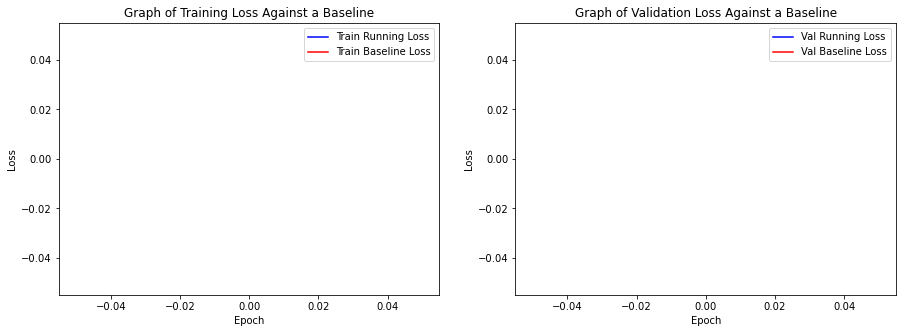

In [14]:
l = len(trloss)
x = np.arange(l)
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
            
axes[0].plot(x, trloss[0:l], label="Train Running Loss", c="blue")
axes[0].plot(x, trbase[0:l], label="Train Baseline Loss", c="red")
axes[0].set_title("Graph of Training Loss Against a Baseline")
axes[0].set(xlabel="Epoch", ylabel="Loss")
axes[0].legend(loc="upper right")

axes[1].plot(x, vloss[0:l], label="Val Running Loss", c="blue")
axes[1].plot(x, vbase[0:l], label="Val Baseline Loss", c="red")
axes[1].set_title("Graph of Validation Loss Against a Baseline")
axes[1].set(xlabel="Epoch", ylabel="Loss")
axes[1].legend(loc="upper right")

plt.show()

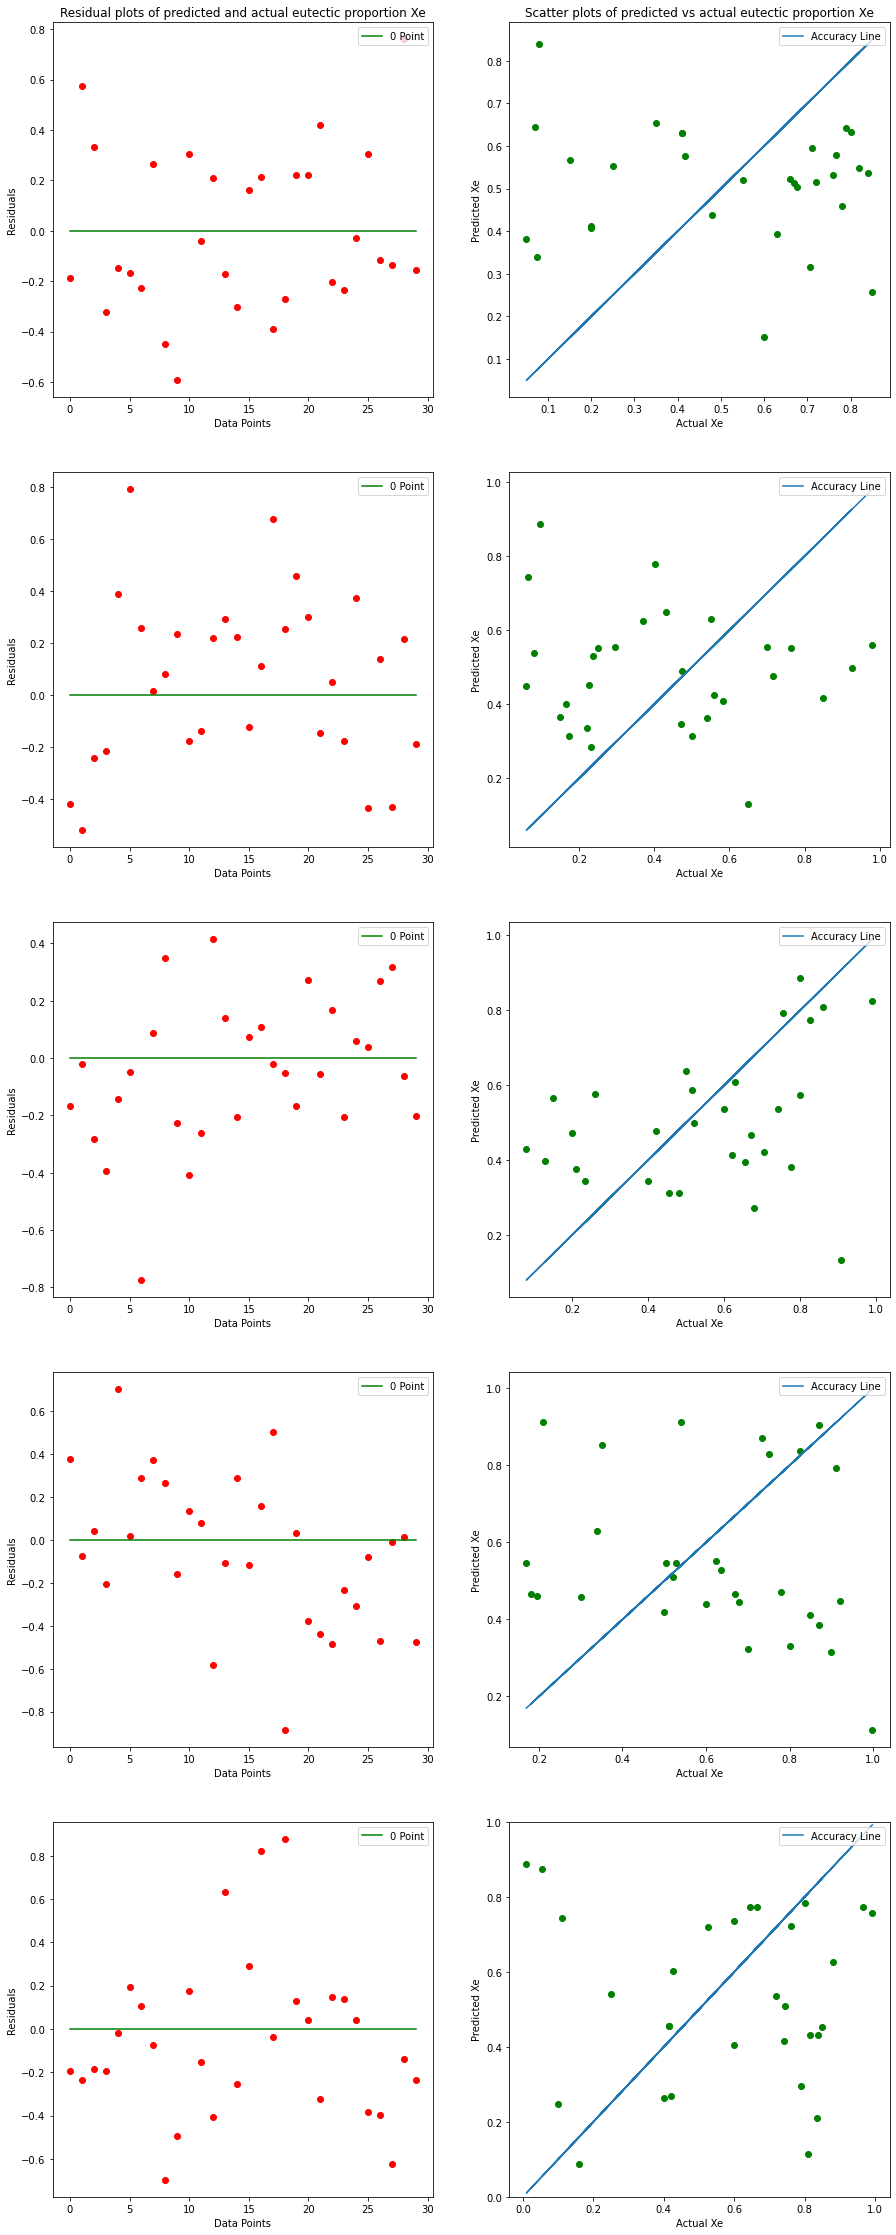

In [15]:
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(15)

l = batchsize
pred = 0
succ = 1
x = np.arange(l)
        
for row in range(5):
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(truths[pred*l:succ*l], outputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(truths[pred*l:succ*l], truths[pred*l:succ*l], label="Accuracy Line")
    axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    axes[row, 1].legend(loc="upper right")

    plt.ylim([0, 1])
            
    pred += 1
    succ += 1
    
axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
plt.show()

In [16]:
# Print the values from the last batch processed just for the user to see
disp = pd.DataFrame({
    'f(A,B)': np.round(outputs[0:l], 3),
    'f(B,A)': np.round(invouts[0:l], 3),
    'f(A,B) + f(B,A)': outputs[0:l] + invouts[0:l],
    'Truth': np.round(truths[0:l], 3),
    'Pred': np.round(outputs[0:l], 3)})
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B)","f(B,A)","f(A,B) + f(B,A)",Truth,Pred
0,0.578000,0.422000,1.000000,0.766000,0.578000
1,0.643000,0.357000,1.000000,0.070000,0.643000
2,0.383000,0.617000,1.000000,0.050000,0.383000
3,0.459000,0.541000,1.000000,0.780000,0.459000
4,0.642000,0.358000,1.000000,0.790000,0.642000
5,0.632000,0.368000,1.000000,0.800000,0.632000
6,0.531000,0.469000,1.000000,0.758000,0.531000
7,0.340000,0.660000,1.000000,0.075000,0.340000
8,0.153000,0.847000,1.000000,0.600000,0.153000
9,0.257000,0.743000,1.000000,0.850000,0.257000


In [18]:
# fig.savefig('D:\\Research\\UConn_ML\\Images\\plots3_7_14_22.png')